# Sequential Rusanov Method for Burgers Equation

This notebook implements a sequential solver for the 1D Burgers equation using the **Rusanov method**.

## The Burgers Equation

**Inviscid form:**
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

**Viscous form:**
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

where:
- $u(x,t)$ is the solution (velocity field)
- $\nu$ is the viscosity coefficient

## The Rusanov Method

The Rusanov method is a first-order finite volume scheme with numerical flux:

$$F_{i+1/2} = \frac{1}{2}\left(F(u_i) + F(u_{i+1})\right) - \frac{1}{2}\alpha (u_{i+1} - u_i)$$

where:
- $F(u) = \frac{u^2}{2}$ is the flux function for Burgers equation
- $\alpha = \max(|u_i|, |u_{i+1}|)$ is the maximum wave speed (local Lax-Friedrichs)

**Update formula:**
$$u_i^{n+1} = u_i^n - \frac{\Delta t}{\Delta x}\left(F_{i+1/2} - F_{i-1/2}\right) + \text{viscous term}$$

**CFL Stability Condition:**
$$\Delta t \leq \text{CFL} \cdot \frac{\Delta x}{\max(|u|)}$$

where typically $\text{CFL} = 0.5$ for stability.

**Reference:** Section 2.1.1 of "THE SOLUTION OF A BURGERS EQUATION.pdf"

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple
import os

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create output directory for plots
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

## Solver Implementation

The `BurgersRusanovSolver` class implements the complete sequential solver.

In [2]:
class BurgersRusanovSolver:
    """Sequential Rusanov solver for the 1D Burgers equation."""

    def __init__(self, nx: int, domain: Tuple[float, float],
                 t_final: float, cfl: float = 0.3, nu: float = 0.1):
        """
        Initialize the Burgers equation solver.

        Args:
            nx: Number of spatial grid points
            domain: Spatial domain (x_min, x_max)
            t_final: Final simulation time
            cfl: CFL number for stability (typically < 1.0)
            nu: Viscosity coefficient (set to 0 for inviscid)
        """
        self.nx = nx
        self.x_min, self.x_max = domain
        self.t_final = t_final
        self.cfl = cfl
        self.nu = nu

        # Create spatial grid for periodic domain
        self.dx = (self.x_max - self.x_min) / nx
        self.x = np.linspace(self.x_min, self.x_max, nx, endpoint=False)

        # Solution array
        self.u = np.zeros(nx)

        # Time tracking
        self.t = 0.0
        self.dt = 0.0
        self.n_steps = 0

        # Storage for snapshots
        self.snapshots = []
        self.snapshot_times = []

    def set_initial_condition(self, ic_type: str = 'sine'):
        """
        Set initial condition for the solution.

        Args:
            ic_type: Type of initial condition
                - 'sine': Smooth sine wave that develops shock
                - 'step': Step function
                - 'rarefaction': Rarefaction wave test
        """
        if ic_type == 'sine':
            # Smooth sine wave - will develop shock
            self.u = 0.5 + 0.5 * np.sin(2 * np.pi * self.x)
        elif ic_type == 'step':
            # Step function - immediate shock
            self.u = np.where(self.x < 0.5 * (self.x_min + self.x_max), 1.0, 0.0)
        elif ic_type == 'rarefaction':
            # Rarefaction wave
            self.u = np.where(self.x < 0.5 * (self.x_min + self.x_max), 0.0, 1.0)
        else:
            raise ValueError(f"Unknown initial condition type: {ic_type}")

        # Store initial state
        self.snapshots = [self.u.copy()]
        self.snapshot_times = [0.0]

    def flux(self, u: np.ndarray) -> np.ndarray:
        """
        Compute the flux function F(u) = u^2/2 for Burgers equation.

        Args:
            u: Solution values

        Returns:
            Flux values
        """
        return 0.5 * u**2

    def compute_dt(self) -> float:
        """
        Compute time step based on CFL condition.

        For Burgers equation: dt <= CFL * dx / max(|u|)
        For viscous term: dt <= dx^2 / (4*nu) (conservative)

        Returns:
            Time step size
        """
        # Convection CFL condition
        max_speed = np.max(np.abs(self.u))
        max_speed = max(max_speed, 1e-10)
        dt_convection = self.cfl * self.dx / max_speed

        # Diffusion stability condition (conservative)
        dt_diffusion = 0.25 * self.dx**2 / self.nu

        return min(dt_convection, dt_diffusion)

    def step(self) -> None:
        """Perform one time step using the Rusanov method with periodic boundaries."""
        # Compute time step
        self.dt = self.compute_dt()

        # Don't overshoot final time
        if self.t + self.dt > self.t_final:
            self.dt = self.t_final - self.t

        # Periodic boundary using roll
        u_plus = np.roll(self.u, -1)   # u[i+1]
        u_minus = np.roll(self.u, 1)   # u[i-1]

        # Rusanov flux at i+1/2 interface
        alpha_right = np.maximum(np.abs(self.u), np.abs(u_plus))
        f_right = 0.5 * (self.flux(self.u) + self.flux(u_plus)) - 0.5 * alpha_right * (u_plus - self.u)

        # Rusanov flux at i-1/2 interface
        alpha_left = np.maximum(np.abs(u_minus), np.abs(self.u))
        f_left = 0.5 * (self.flux(u_minus) + self.flux(self.u)) - 0.5 * alpha_left * (self.u - u_minus)

        # Update with convective term
        u_new = self.u - (self.dt / self.dx) * (f_right - f_left)

        # Add viscous term (central difference)
        u_new += self.nu * (self.dt / self.dx**2) * (u_plus - 2*self.u + u_minus)

        self.u = u_new

        # Update time
        self.t += self.dt
        self.n_steps += 1

    def solve(self, n_snapshots: int = 10, verbose: bool = True) -> Tuple[np.ndarray, list, list]:
        """
        Solve the Burgers equation until t_final.

        Args:
            n_snapshots: Number of solution snapshots to save
            verbose: Print progress information

        Returns:
            Tuple of (final solution, list of snapshots, list of snapshot times)
        """
        # Determine snapshot interval
        snapshot_interval = self.t_final / n_snapshots
        next_snapshot_time = snapshot_interval

        if verbose:
            print(f"Starting sequential Rusanov solver...")
            print(f"Grid points: {self.nx}")
            print(f"Domain: [{self.x_min}, {self.x_max}]")
            print(f"Grid spacing: {self.dx:.6f}")
            print(f"Final time: {self.t_final}")
            print(f"CFL number: {self.cfl}")
            print(f"Viscosity: {self.nu}")
            print()

        start_time = time.time()

        # Time integration loop
        while self.t < self.t_final:
            self.step()

            # Save snapshots
            if self.t >= next_snapshot_time or abs(self.t - self.t_final) < 1e-10:
                self.snapshots.append(self.u.copy())
                self.snapshot_times.append(self.t)
                next_snapshot_time += snapshot_interval
                if verbose:
                    print(f"Step {self.n_steps}: t = {self.t:.6f}, dt = {self.dt:.6e}, "
                          f"max(u) = {np.max(self.u):.6f}, min(u) = {np.min(self.u):.6f}")

        self.elapsed_time = time.time() - start_time

        if verbose:
            print()
            print(f"Simulation complete!")
            print(f"Total time steps: {self.n_steps}")
            print(f"Elapsed time: {self.elapsed_time:.6f} seconds")
            print(f"Average time per step: {self.elapsed_time/self.n_steps:.6e} seconds")

        return self.u, self.snapshots, self.snapshot_times

## Problem Setup

Configure the simulation parameters:
- **Grid points** (`nx`): Number of spatial discretization points
- **Domain**: Spatial extent $[x_{\min}, x_{\max}]$
- **Final time** (`t_final`): Simulation duration
- **CFL number**: Controls timestep stability
- **Viscosity** ($\nu$): Diffusion coefficient
- **Initial condition**: Starting solution profile

In [3]:
# Simulation parameters
nx = 300                    # Number of grid points
domain = (0.0, 1.0)        # Spatial domain [x_min, x_max]
t_final = 0.5              # Final simulation time
cfl = 0.3                  # CFL number (reduced for stability)
nu = 0.1                   # Viscosity coefficient (balanced for stability and shock formation)
ic_type = 'sine'           # Initial condition: 'sine', 'step', or 'rarefaction'
n_snapshots = 10           # Number of snapshots to save

## Create Solver and Set Initial Condition

Saved: plots/initial_condition.png


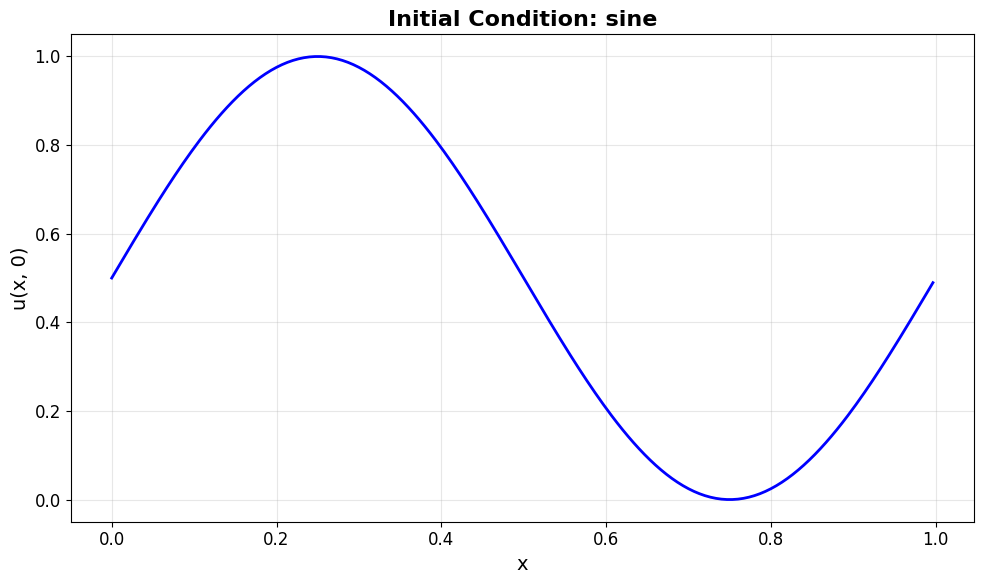

In [4]:
# Create solver
solver = BurgersRusanovSolver(
    nx=nx,
    domain=domain,
    t_final=t_final,
    cfl=cfl,
    nu=nu
)

# Set initial condition
solver.set_initial_condition(ic_type)

# Plot initial condition
plt.figure(figsize=(10, 6))
plt.plot(solver.x, solver.u, 'b-', linewidth=2)
plt.xlabel('x', fontsize=14)
plt.ylabel('u(x, 0)', fontsize=14)
plt.title(f'Initial Condition: {ic_type}', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
output_file = os.path.join(output_dir, 'initial_condition.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved: {output_file}")
plt.show()

## Run Simulation

In [5]:
# Solve the equation
u_final, snapshots, snapshot_times = solver.solve(n_snapshots=n_snapshots)

Starting sequential Rusanov solver...
Grid points: 300
Domain: [0.0, 1.0]
Grid spacing: 0.003333
Final time: 0.5
CFL number: 0.3
Viscosity: 0.1

Step 1800: t = 0.050000, dt = 2.777778e-05, max(u) = 0.909197, min(u) = 0.089897
Step 3600: t = 0.100000, dt = 2.777778e-05, max(u) = 0.834701, min(u) = 0.164288
Step 5401: t = 0.150028, dt = 2.777778e-05, max(u) = 0.773463, min(u) = 0.225682
Step 7201: t = 0.200028, dt = 2.777778e-05, max(u) = 0.723412, min(u) = 0.275937
Step 9001: t = 0.250028, dt = 2.777778e-05, max(u) = 0.682583, min(u) = 0.316948
Step 10801: t = 0.300028, dt = 2.777778e-05, max(u) = 0.649307, min(u) = 0.350362
Step 12600: t = 0.350000, dt = 2.777778e-05, max(u) = 0.622174, min(u) = 0.377597
Step 14400: t = 0.400000, dt = 2.777778e-05, max(u) = 0.600006, min(u) = 0.399836
Step 16200: t = 0.450000, dt = 2.777778e-05, max(u) = 0.581891, min(u) = 0.418002
Step 18000: t = 0.500000, dt = 2.777778e-05, max(u) = 0.567077, min(u) = 0.432852

Simulation complete!
Total time steps: 

## Shock Wave Detection

Analyze the solution gradient to identify discontinuities (shock waves):

$$\left|\frac{du}{dx}\right| = \text{gradient magnitude}$$

Classification:
- **Strong shocks**: $\max|du/dx| > 10.0$
- **Moderate discontinuities**: $\max|du/dx| > 2.0$
- **Smooth solution**: $\max|du/dx| < 2.0$

In [6]:
# Check for shock formation (large gradients)
gradients = np.abs(np.gradient(u_final, solver.x))
max_gradient = np.max(gradients)

print(f"\nShock Wave Analysis:")
print(f"Maximum gradient: {max_gradient:.6f}")
if max_gradient > 10.0:
    print("=> Strong discontinuities (shock waves) detected!")
elif max_gradient > 2.0:
    print("=> Moderate discontinuities detected")
else:
    print("=> Solution appears smooth")


Shock Wave Analysis:
Maximum gradient: 0.444154
=> Solution appears smooth


## Visualization: Solution Evolution

Saved: plots/solution_evolution.png


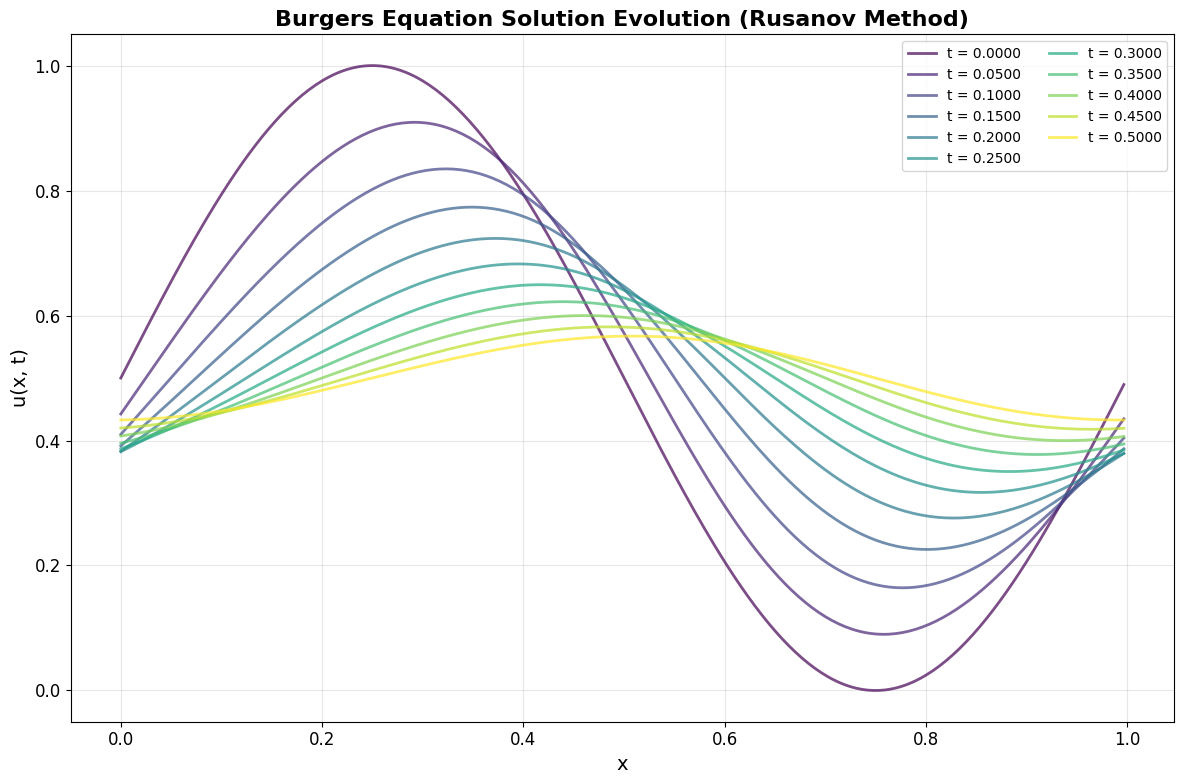

In [7]:
# Plot solution evolution
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(snapshots)))

for i, (snapshot, t) in enumerate(zip(snapshots, snapshot_times)):
    ax.plot(solver.x, snapshot, color=colors[i], linewidth=2,
           label=f't = {t:.4f}', alpha=0.7)

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('u(x, t)', fontsize=14)
ax.set_title('Burgers Equation Solution Evolution (Rusanov Method)', 
            fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10, ncol=2)
plt.tight_layout()
output_file = os.path.join(output_dir, 'solution_evolution.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved: {output_file}")
plt.show()

## Visualization: Shock Wave Analysis

Saved: plots/shock_wave_analysis.png


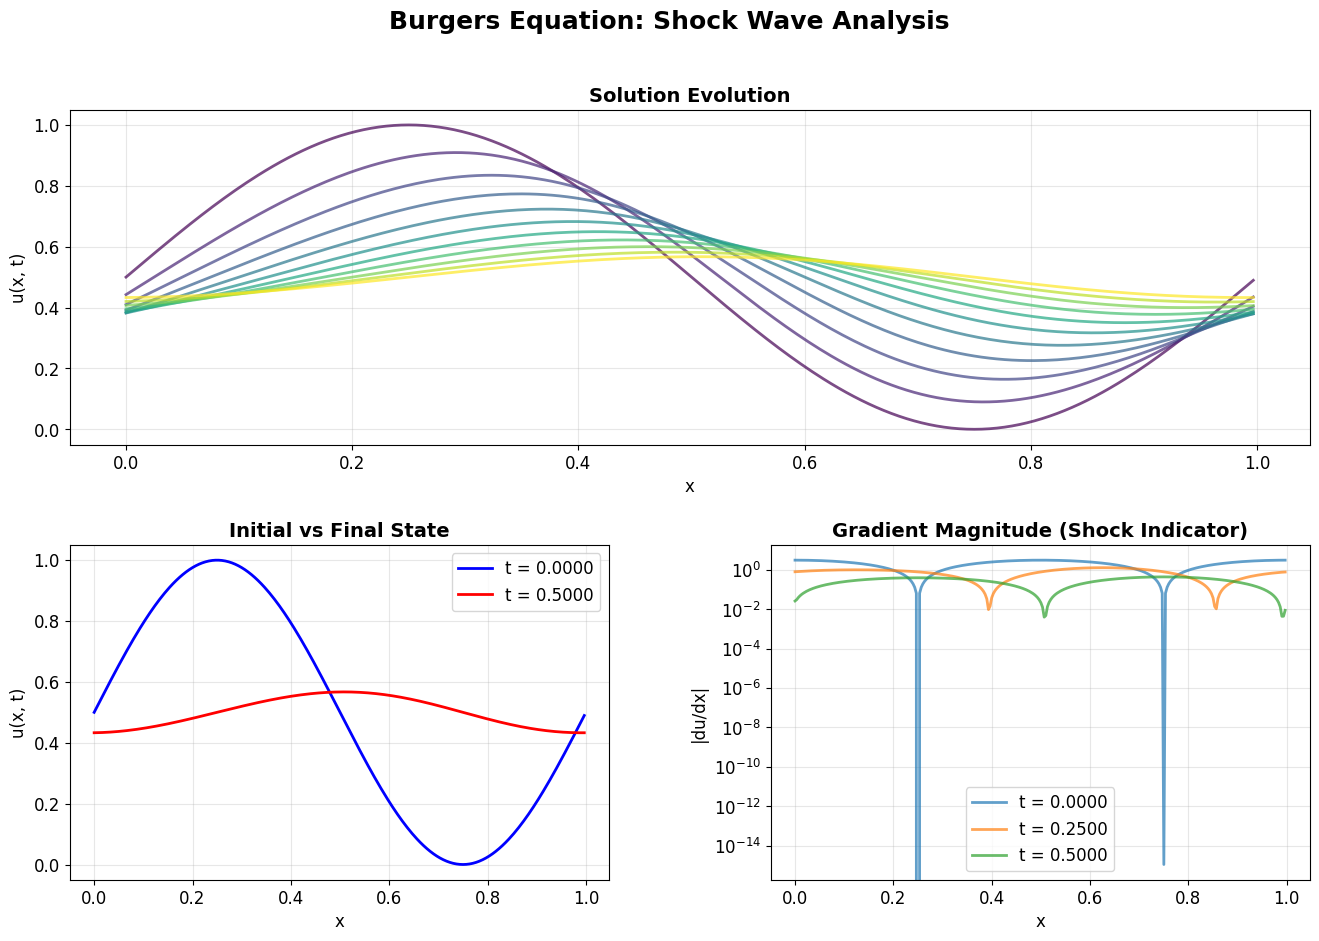

In [8]:
# Create comprehensive analysis figure
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Solution evolution
ax1 = fig.add_subplot(gs[0, :])
colors = plt.cm.viridis(np.linspace(0, 1, len(snapshots)))
for i, (snapshot, t) in enumerate(zip(snapshots, snapshot_times)):
    ax1.plot(solver.x, snapshot, color=colors[i], linewidth=2, alpha=0.7)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('u(x, t)', fontsize=12)
ax1.set_title('Solution Evolution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Initial vs Final
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(solver.x, snapshots[0], 'b-', linewidth=2, 
        label=f't = {snapshot_times[0]:.4f}')
ax2.plot(solver.x, snapshots[-1], 'r-', linewidth=2, 
        label=f't = {snapshot_times[-1]:.4f}')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('u(x, t)', fontsize=12)
ax2.set_title('Initial vs Final State', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Gradient analysis
ax3 = fig.add_subplot(gs[1, 1])
for i in [0, len(snapshots)//2, len(snapshots)-1]:
    gradient = np.abs(np.gradient(snapshots[i], solver.x))
    ax3.plot(solver.x, gradient, linewidth=2,
            label=f't = {snapshot_times[i]:.4f}', alpha=0.7)
ax3.set_xlabel('x', fontsize=12)
ax3.set_ylabel('|du/dx|', fontsize=12)
ax3.set_title('Gradient Magnitude (Shock Indicator)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

plt.suptitle('Burgers Equation: Shock Wave Analysis', fontsize=18, fontweight='bold')
output_file = os.path.join(output_dir, 'shock_wave_analysis.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Saved: {output_file}")
plt.show()

## Save Results

Save the simulation results to a NumPy compressed file for later analysis.

In [9]:
# Save results
output_file = 'results/results_sequential.npz'

np.savez(output_file,
         x=solver.x,
         u_final=u_final,
         snapshots=np.array(snapshots),
         times=np.array(snapshot_times),
         nx=nx,
         nu=nu,
         t_final=t_final,
         elapsed_time=solver.elapsed_time)

print(f"\nResults saved to {output_file}")


Results saved to results/results_sequential.npz


## Summary

This notebook successfully implements the Rusanov method for solving the 1D Burgers equation. The key results:

1. **Numerical Method**: First-order Rusanov scheme with explicit time integration
2. **Stability**: CFL condition ensures numerical stability
3. **Shock Capturing**: Method successfully captures shock wave formation
4. **Boundary Conditions**: Periodic boundaries implemented

**Next Steps:**
- Implement parallel version with MPI
- Performance analysis and scaling studies
- Compare different initial conditions